<a href="https://colab.research.google.com/github/azzindani/02_Deep_Learning_NLP/blob/main/NLP_Discord_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version 20240825

## 00 Importing Modules

In [1]:
!pip install google-play-scraper

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from google_play_scraper import Sort, reviews_all
from tensorflow.keras import layers, Model, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam
import re

%matplotlib inline

## 01 Data Collection with Google Playstore Scrapper

In [3]:
scrapReview = reviews_all(
  'com.discord',
  lang = 'en',
  country = 'us',
  sort = Sort.MOST_RELEVANT,
  count = 1000
)

# com.hoyoverse.cloudgames.GenshinImpact
# com.YoStarEN.Arknights
# com.discord

## 02 Create & Structuring Dataframe

In [4]:
df = pd.DataFrame(scrapReview)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85500 entries, 0 to 85499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              85500 non-null  object        
 1   userName              85500 non-null  object        
 2   userImage             85500 non-null  object        
 3   content               85500 non-null  object        
 4   score                 85500 non-null  int64         
 5   thumbsUpCount         85500 non-null  int64         
 6   reviewCreatedVersion  74484 non-null  object        
 7   at                    85500 non-null  datetime64[ns]
 8   replyContent          32161 non-null  object        
 9   repliedAt             32161 non-null  datetime64[ns]
 10  appVersion            74484 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 7.2+ MB


In [5]:
df = df[['content', 'score']]
df.head(2)

,content,score
0,App constantly jumps back to the bottom to sho...,1
1,Excellent app for communication with my friend...,3


In [6]:
df.dropna(inplace = True)
df.shape

(85500, 2)

## 03 Labeling & Classify

### 03.01 Using "VADER"

In [7]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['content']
    id = i
    res[id] = sia.polarity_scores(text)

  0%|          | 0/85500 [00:00<?, ?it/s]

In [9]:
df1 = pd.DataFrame(res).T
df1 = pd.concat([df, df1], axis = 1)
df1.head(2)

,content,score,neg,neu,pos,compound
0,App constantly jumps back to the bottom to sho...,1,0.077,0.886,0.037,-0.4588
1,Excellent app for communication with my friend...,3,0.000,0.782,0.218,0.9581


In [10]:
def label_func(compound):
  if compound >= 0.5:
    return 'Positive'
  elif compound <= -0.5:
    return 'Negative'
  else:
    return 'Neutral'

df1['label'] = df1['compound'].apply(label_func)
df1.head(2)

,content,score,neg,neu,pos,compound,label
0,App constantly jumps back to the bottom to sho...,1,0.077,0.886,0.037,-0.4588,Neutral
1,Excellent app for communication with my friend...,3,0.000,0.782,0.218,0.9581,Positive


### 03.02 Using Score

In [11]:
'''def label_func(compound):
  if compound >= 5:
    return 'Positive'
  elif compound <= 3:
    return 'Negative'
  else:
    return 'Neutral'

df1['label'] = df1['score'].apply(label_func)
df1.head(2) #'''

"def label_func(compound):\n  if compound >= 5:\n    return 'Positive'\n  elif compound <= 3:\n    return 'Negative'\n  else:\n    return 'Neutral'\n\ndf1['label'] = df1['score'].apply(label_func)\ndf1.head(2) #"

## 04 Data Cleaning

In [12]:
x_var = 'content'
y_var = 'label'

In [13]:
final_df = df1

In [14]:
final_df = final_df[[x_var, y_var]]
final_df.head(2)

,content,label
0,App constantly jumps back to the bottom to sho...,Neutral
1,Excellent app for communication with my friend...,Positive


In [15]:
final_df['len'] = final_df[x_var].apply(lambda x: len(str(x).split()))
final_df['len'] = final_df['len'].fillna(0)
final_df['len'] = final_df['len'].astype('int')
final_df.head(2)

<ipython-input-15-8d708c41e6f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['len'] = final_df[x_var].apply(lambda x: len(str(x).split()))
<ipython-input-15-8d708c41e6f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['len'] = final_df['len'].fillna(0)
<ipython-input-15-8d708c41e6f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,content,label,len
0,App constantly jumps back to the bottom to sho...,Neutral,95
1,Excellent app for communication with my friend...,Positive,77


In [16]:
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+','', text) #remove mentions
    text = re.sub(r'#','', text) #remove hash
    text = re.sub(r'https?:\/\/\S+', '', text) #remove hyperlink
    text = re.sub('\s+', ' ', text) #remove new line char
    text = re.sub("\'", "", text) #remove single quotes

    return text

In [17]:
final_df['content'] = final_df['content'].apply(cleantext)

<ipython-input-17-950a3fa653af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['content'] = final_df['content'].apply(cleantext)


## 05 Data Balancing

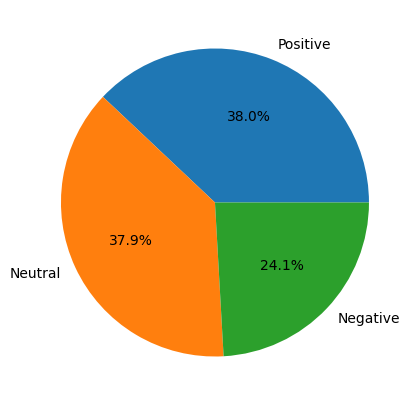

In [18]:
fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in final_df[y_var].value_counts()]
labels = list(final_df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show()

In [19]:
n = 10000
append_data = []

for i in final_df[y_var].unique():
  df_x = final_df[final_df[y_var] == i][:n]
  append_data.append(df_x)

In [20]:
append_df = pd.concat(append_data)
append_df.shape

(30000, 3)

In [21]:
append_df.head(2)

,content,label,len
0,App constantly jumps back to the bottom to sho...,Neutral,95
3,"For over a year now, even after buying a new p...",Neutral,80


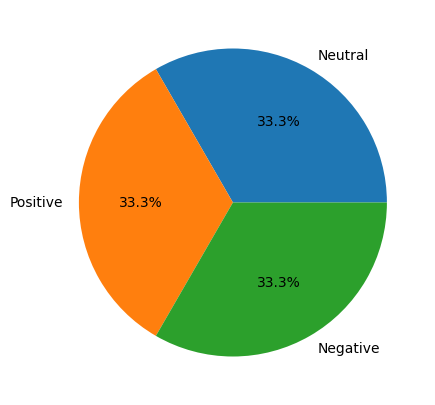

In [22]:
fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in append_df[y_var].value_counts()]
labels = list(append_df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show()

## 06 Create Word Cloud

In [23]:
final_df['content'] = final_df['content'].fillna(value="")

<ipython-input-23-06f44c8453ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['content'] = final_df['content'].fillna(value="")


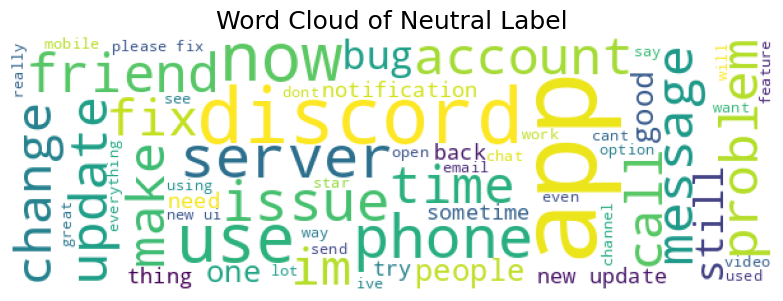

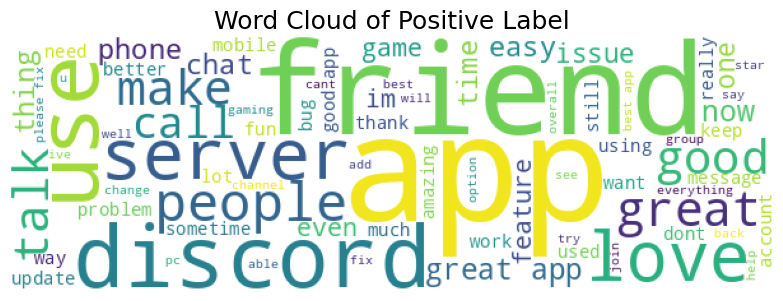

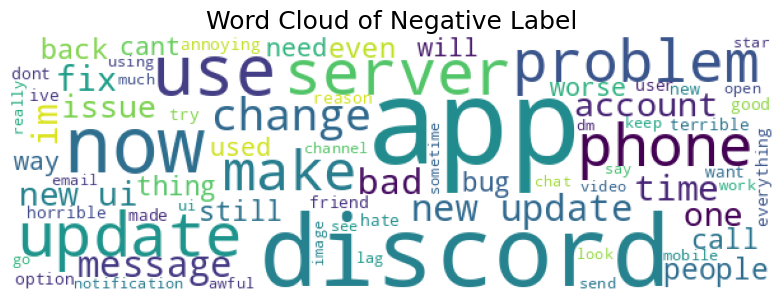

In [24]:
for label in final_df['label'].unique():
    sel_df = final_df[final_df['label'] == label]

    word_string = ' '.join(sel_df['content'] .str.lower())
    wordcloud = WordCloud(
        width = 600,
        height = 200,
        stopwords = STOPWORDS,
        background_color = 'white',
        min_font_size = 10
    ).generate(word_string)

    fig, ax = plt.subplots(figsize = (8, 6))
    ax.set_title('Word Cloud of ' + label + ' Label', fontsize = 18)
    ax.grid(False)
    ax.imshow((wordcloud))
    fig.tight_layout(pad = 0)
    ax.axis('off')
    plt.show()
    print('=' * 100)

## 07 Define X & Y Variable, Data Tokenize (using BERT)

### 07.01 Tokenizer

In [25]:
bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [26]:
max_length = int(append_df['len'].max())
#max_length = int(append_df['len'].mean())
#max_length = 256

tkn = list(append_df[x_var])
tkn = bertTokenizer(
  tkn,
  padding = True,
  truncation = True,
  max_length = max_length,
)

In [27]:
# only for generated token preview

df_tkn = pd.DataFrame.from_dict(tkn, orient = 'index').T
df_tkn.head(2)

,input_ids,token_type_ids,attention_mask
0,"[101, 10439, 7887, 14523, 2067, 2000, 1996, 39...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[101, 2005, 2058, 1037, 2095, 2085, 1010, 2130...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### 07.02 Create Class Dict

In [28]:
class_dict = {}
count = 0
for cat in append_df[y_var].unique():
  class_dict[cat] = count
  count = count + 1

class_dict #'''

{'Neutral': 0, 'Positive': 1, 'Negative': 2}

In [29]:
rev_class_dict = {v: k for k, v in class_dict.items()}

In [30]:
append_df[y_var] = append_df[y_var].replace(class_dict)

### 07.03 Define Input & Output Variable

In [31]:
txt_ids = np.array(tkn['input_ids'])
txt_tids  = np.array(tkn['token_type_ids'])
txt_am = np.array(tkn['attention_mask'])

In [32]:
y = np.array(append_df[y_var])

In [33]:
y_classes = len(append_df[y_var].unique())
y_classes

3

## 08 Building Model

In [34]:
vocab_size = bertTokenizer.vocab_size    # Vocabulary size (number of unique words in the dataset)
embedding_dim = 128   # Dimension of word embeddings
max_length = txt_ids.shape[1]      # Maximum length of input sequences

In [35]:
input_token = layers.Input(shape = (max_length,), dtype = tf.int32, name = 'input_token')

x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(input_token)
x = layers.Bidirectional(layers.LSTM(embedding_dim))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(embedding_dim, activation = 'relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(embedding_dim, activation = 'relu')(x)
x = layers.Dense(y_classes, activation = 'softmax')(x)

model = Model(inputs = input_token, outputs = x)
model.summary() #'''

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_token (InputLayer)             │ (None, 236)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 236, 128)            │       3,906,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,220,803 (16.10 MB)

 Trainable params: 4,220,291 (16.10 MB)

 Non-trainable params: 512 (2.00 KB)

## 09 Training Model

In [36]:
model.compile(
  loss = losses.sparse_categorical_crossentropy, #'categorical_crossentropy',
  optimizer = Adam(learning_rate = 1e-4),
  metrics = ['accuracy']
)

In [37]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
  def __init__(self, threshold):
    super(MyThresholdCallback, self).__init__()
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs=None):
    val_acc = logs['val_accuracy']
    acc = logs['accuracy']
    if val_acc >= self.threshold and acc >= self.threshold:
        self.model.stop_training = True

In [38]:
es_callback = MyThresholdCallback(threshold = 0.95)

In [39]:
num_epochs = 100

history = model.fit(
  txt_ids,# txt_tids, txt_am],
  y,
  batch_size = 128,
  epochs = num_epochs,
  validation_split = 0.2,
  shuffle = True,
  verbose = 1,
  callbacks = es_callback
)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.4670 - loss: 1.0412 - val_accuracy: 0.0000e+00 - val_loss: 1.4699
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6518 - loss: 0.7665 - val_accuracy: 0.8458 - val_loss: 0.7066
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7527 - loss: 0.5749 - val_accuracy: 0.6942 - val_loss: 0.6258
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8009 - loss: 0.4922 - val_accuracy: 0.7277 - val_loss: 0.6984
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8298 - loss: 0.4311 - val_accuracy: 0.8275 - val_loss: 0.4636
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8498 - loss: 0.3880 - val_accuracy: 0.9722 - val_loss: 0.1176
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8658 - loss: 0.3548 - val_accuracy: 0.5755 - val_loss: 1.1870
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8740 - loss: 

## 10 Checking Result

### 10.01 Training Progress

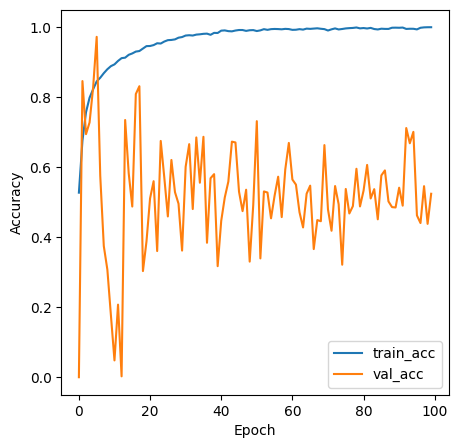

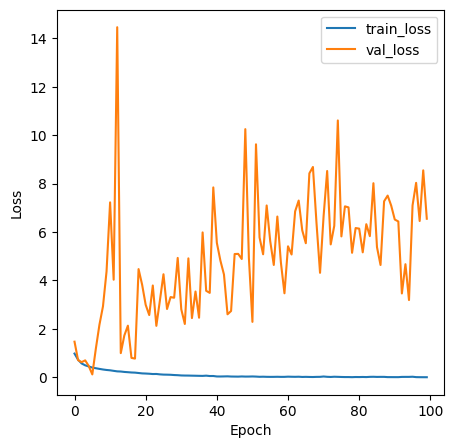

In [40]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (5, 5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 10.02 Classification Report

In [41]:
y_predicted = np.argmax(model.predict(txt_ids), axis = -1)
cr = classification_report(y, y_predicted)

print('Classification Report\n', cr)

938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
Classification Report
               precision    recall  f1-score   support

           0       0.81      1.00      0.89     10000
           1       0.95      1.00      0.98     10000
           2       1.00      0.71      0.83     10000

    accuracy                           0.90     30000
   macro avg       0.92      0.90      0.90     30000
weighted avg       0.92      0.90      0.90     30000



### 10.03 Confusion Matrix

Confusion Matrix


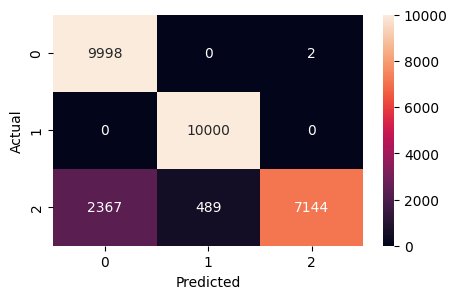

In [42]:
cm = confusion_matrix(y, y_predicted)

print('Confusion Matrix')
plt.figure(figsize = (5, 3))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() #'''